# Mayeul's Notebook for group project


## Team 2 Wind prediction team

# EDA

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import imageio
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [5]:
bkh = pd.read_csv('storm_csv/combined_data_bkh.csv')
bkh

,storm_id,relative_time,ocean,wind_speed,image_file_name
0,bkh,0,1,25,bkh_000.jpg
1,bkh,1801,1,25,bkh_001.jpg
2,bkh,3600,1,25,bkh_002.jpg
3,bkh,5400,1,25,bkh_003.jpg
4,bkh,7200,1,25,bkh_004.jpg
...,...,...,...,...,...
405,bkh,1022400,1,30,bkh_405.jpg
406,bkh,1026001,1,30,bkh_406.jpg
407,bkh,1027801,1,30,bkh_407.jpg
408,bkh,1029601,1,30,bkh_408.jpg


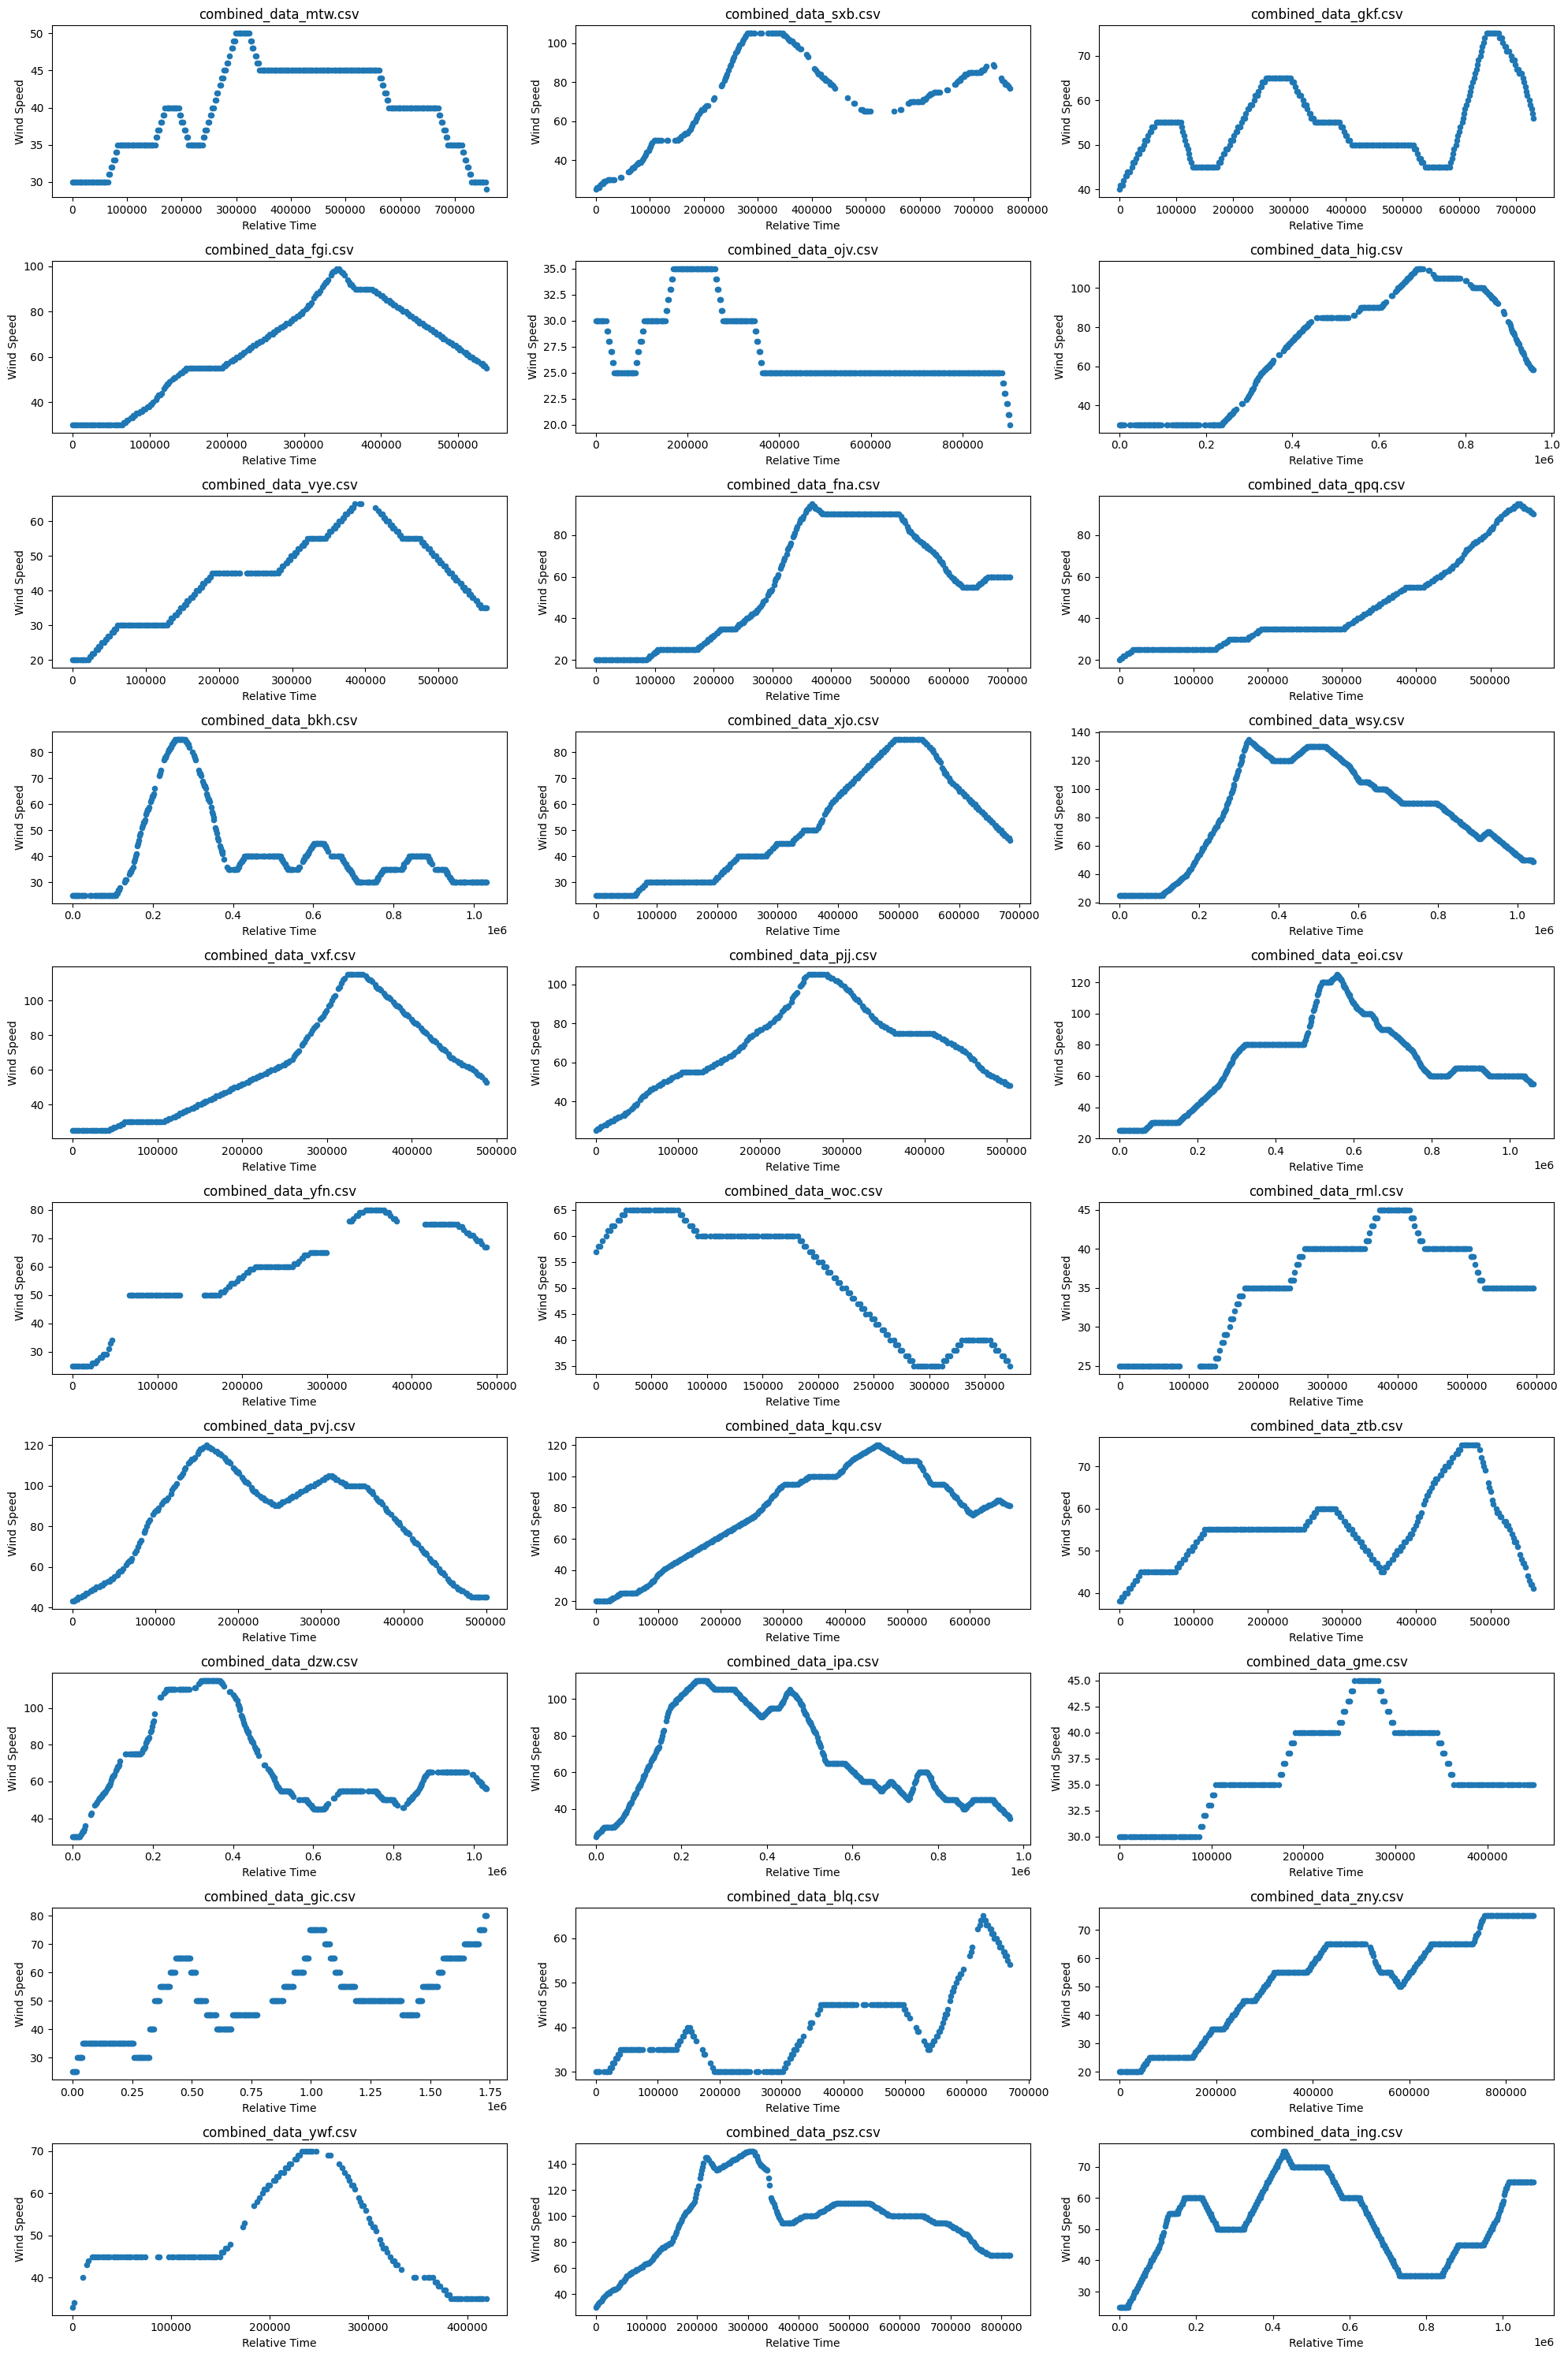

In [6]:
# Get all CSV files in the storm_data_csv directory
storm_data_csv = './storm_csv'
csv_files = [file for file in os.listdir(storm_data_csv) if file.endswith('.csv')]
fig, axes = plt.subplots(10, 3, figsize=(20, 30))

# Plot wind_speed over relative_time for each CSV file
for i, file in enumerate(csv_files):
    file_path = os.path.join(storm_data_csv, file)
    storm = pd.read_csv(file_path)
    row = i % 10  # Calculate the row index
    col = i // 10  # Calculate the column index
    storm.plot(x='relative_time', y='wind_speed', kind='scatter', ax=axes[row, col])
    axes[row, col].set_xlabel('Relative Time')
    axes[row, col].set_ylabel('Wind Speed')
    axes[row, col].set_title(file)

plt.tight_layout()
plt.show()


--> Different profiles, data missing, time different, wind speed variations

In [7]:
storm = pd.concat([pd.read_csv(os.path.join(storm_data_csv, file)) for file in csv_files])
storm.describe()

,relative_time,ocean,wind_speed
count,9.527000e+03,9527.000000,9527.000000
mean,4.121514e+05,1.196809,58.020153
std,2.943204e+05,0.397608,26.169805
min,0.000000e+00,1.000000,20.000000
25%,1.836000e+05,1.000000,36.000000
50%,3.671990e+05,1.000000,54.000000
75%,5.859000e+05,1.000000,74.000000
max,1.735204e+06,2.000000,150.000000


In [6]:
print('Number of NaN values in each column:')
storm.isna().sum()

Number of NaN values in each column:


storm_id           0
relative_time      0
ocean              0
wind_speed         0
image_file_name    0
dtype: int64

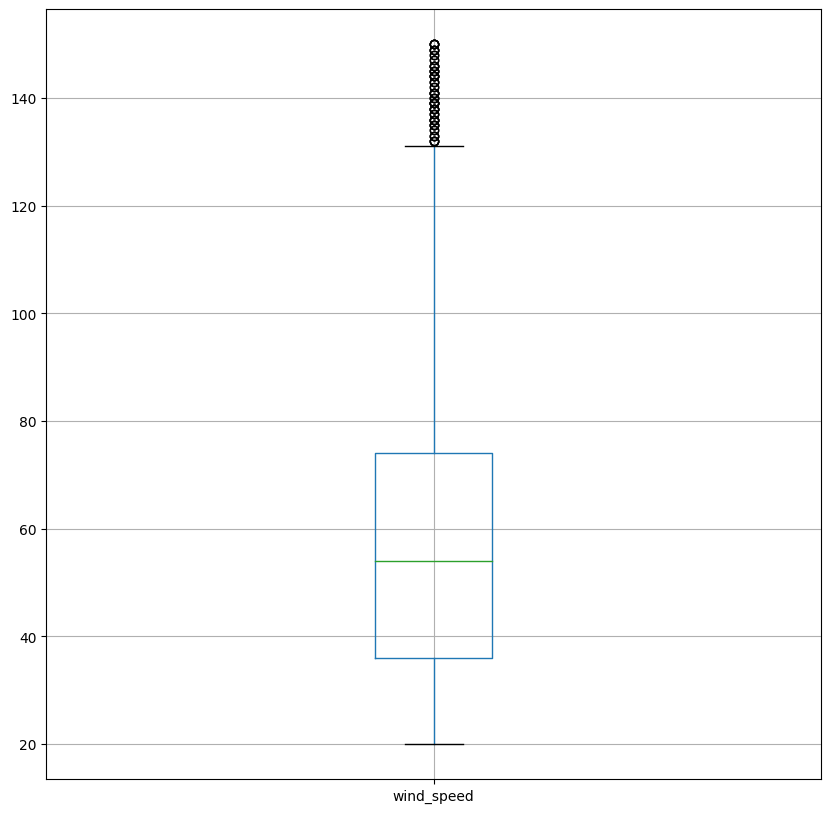

In [7]:
storm.boxplot(column='wind_speed', figsize=(10, 10)); 

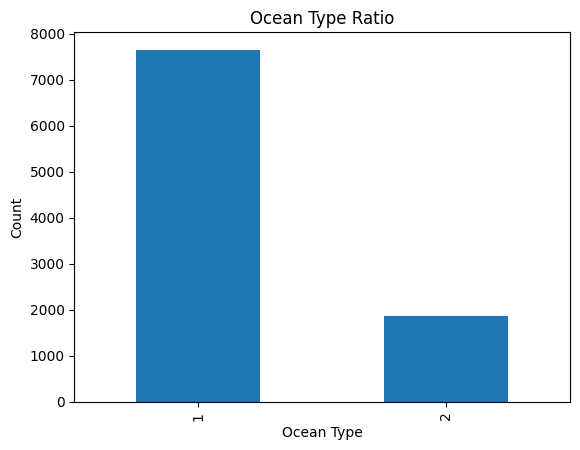

In [8]:
ocean_type_ratio = storm['ocean'].value_counts(normalize=False)
ocean_type_ratio.plot(kind='bar')
plt.xlabel('Ocean Type')
plt.ylabel('Count')
plt.title('Ocean Type Ratio')
plt.show()


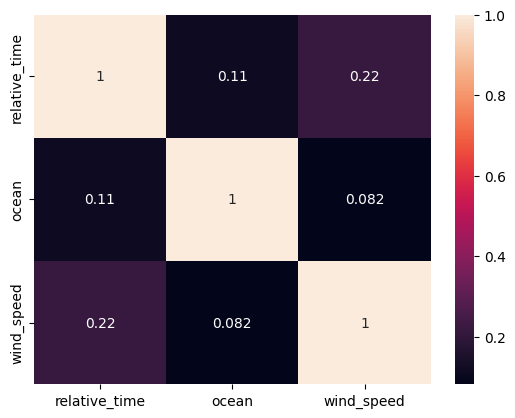

In [9]:
corr_matrix = storm.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()


### Images quick data analysis

In [10]:
images_data = [img for img in os.listdir('all_storm_image') if img.endswith('.jpg')]

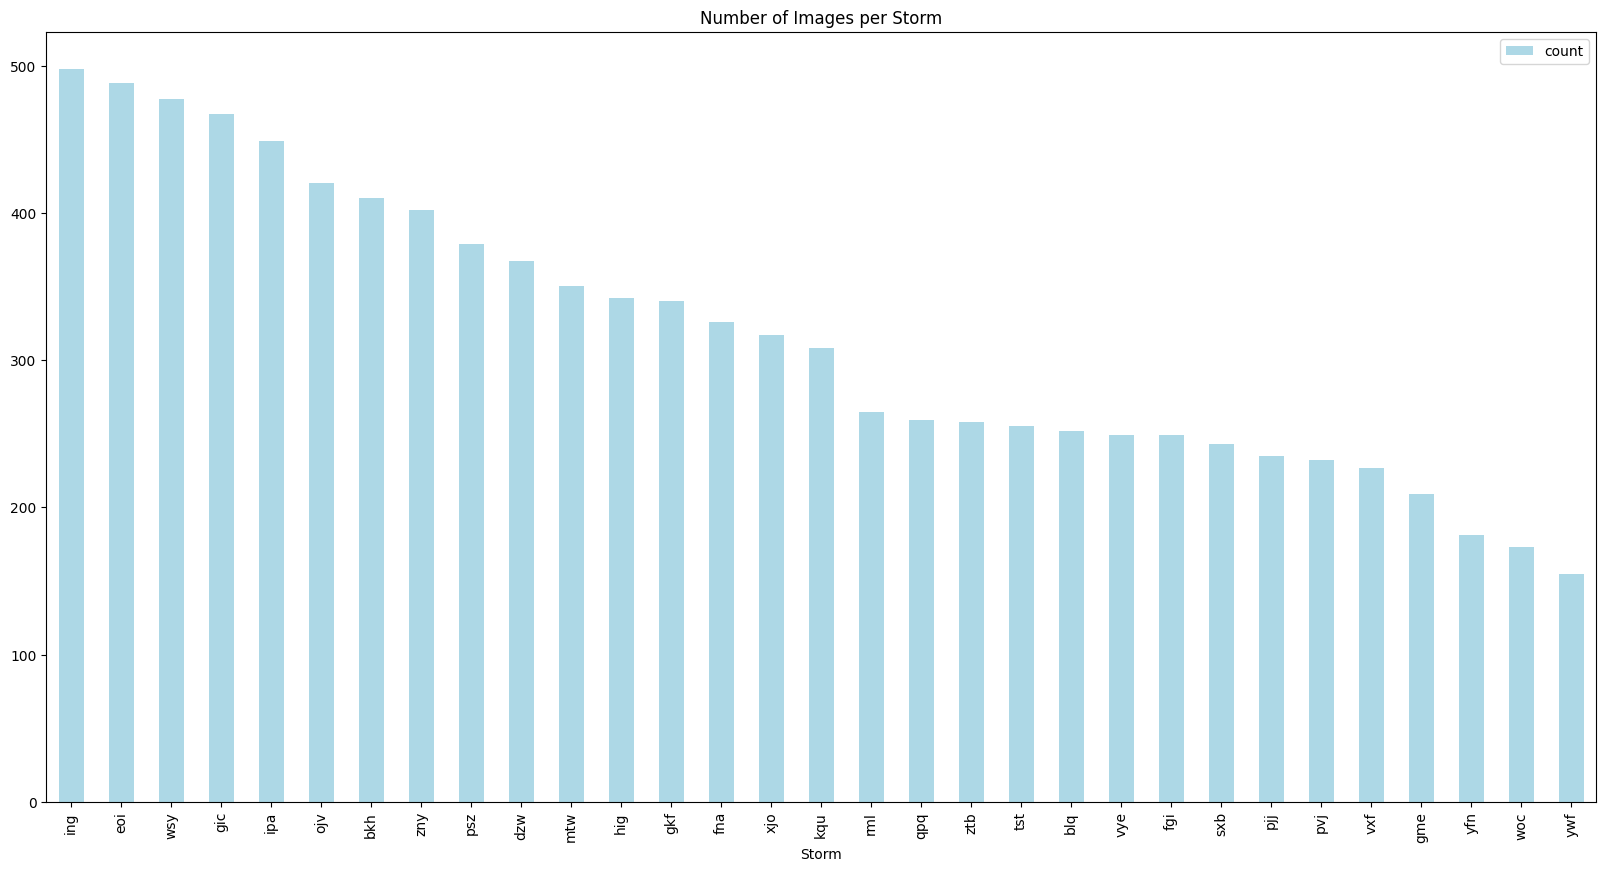

,count
count,31.000000
mean,315.548387
std,99.032600
min,155.000000
25%,246.000000
50%,308.000000
75%,390.500000
max,498.000000


In [11]:
from collections import Counter
storm_count = Counter([img[:3] for img in images_data])
storm_count = pd.DataFrame.from_dict(storm_count, orient='index', columns=['count'])
storm_count.index.name = 'storm'
storm_count.sort_values(by='count', ascending=False, inplace=True)
storm_count.head()

# plot the number of images per storm
storm_count.plot(kind='bar', figsize=(20, 10), color='lightblue')
plt.xlabel('Storm')
plt.title('Number of Images per Storm')
plt.show()
storm_count.describe()


In [12]:
def get_storm_images(storm_ids):
    images = []
    for storm_id in storm_ids:
        for img in images_data:
            if img.startswith(storm_id):
                images.append(img)
    return images

In [15]:
def create_storm_gif(storm_id, save_gif=False):
    images = get_storm_images([storm_id])
    images = sorted(images)
    gif_images = []
    for image in images:
        image_path = os.path.join('all_storm_image', image)
        gif_images.append(imageio.imread(image_path))
    display(Image(data=imageio.mimwrite(imageio.RETURN_BYTES, gif_images, format='gif')))
    if save_gif:
        imageio.mimwrite(f'{storm_id}.gif', gif_images, format='gif')


---
## "Storm intensity": calculating cloud coverage as a feature

In [15]:
# Function to compute cloud coverage
def compute_storm_intensity(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded_image = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
    num_whitish_pixels = cv2.countNonZero(thresholded_image)
    num_non_whitish_pixels = gray_image.size - num_whitish_pixels
    
    # Compute the ratio of whitish pixels to non-whitish pixels (storm intensity/cloud cover)
    storm_intensity = num_whitish_pixels / num_non_whitish_pixels if num_non_whitish_pixels > 0 else 1.0
    return storm_intensity

# Directory containing the storm images
image_directory = 'all_storm_image'

# Iterate through all images in the directory and compute storm intensity
storm_intensities = {}
for filename in os.listdir(image_directory):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_directory, filename)
        storm_intensity = compute_storm_intensity(image_path)
        storm_intensities[filename] = storm_intensity

# add to main dataframe
storm['storm_intensity'] = storm['image_file_name'].map(storm_intensities)
print(storm.head())

  storm_id  relative_time  ocean  wind_speed image_file_name  storm_intensity
0      mtw              0      1          30     mtw_000.jpg         0.645429
1      mtw           1800      1          30     mtw_001.jpg         0.639147
2      mtw           3600      1          30     mtw_002.jpg         0.651046
3      mtw           5400      1          30     mtw_003.jpg         0.626469
4      mtw           7200      1          30     mtw_004.jpg         0.622274


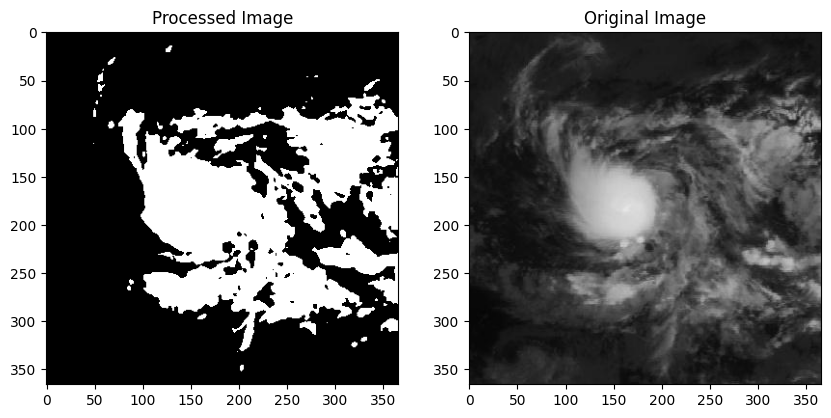

(366, 366)


In [16]:
def img_preprocess(image_path):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (366, 366))
    blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)
    gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
    _, thresholded_image = cv2.threshold(gray_image, 75, 255, cv2.THRESH_BINARY)
    float_image = thresholded_image.astype(np.float32)
    final_image = float_image / 255.0 # Normalize the image
    return final_image

random_image = random.choice(storm['image_file_name'].values)
random_image_path = os.path.join('all_storm_image', random_image)
random_image = cv2.imread(random_image_path)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_preprocess(random_image_path).squeeze(), cmap='gray')
plt.title('Processed Image')
plt.subplot(1, 2, 2)
plt.imshow(random_image)
plt.title('Original Image')
plt.show()
print(img_preprocess(random_image_path).shape)

In [17]:
# map storm intensity to the storm dataset from the storm_data dataset
storm['storm_intensity'] = storm['image_file_name'].map(storm_intensities)
storm.head()

,storm_id,relative_time,ocean,wind_speed,image_file_name,storm_intensity
0,mtw,0,1,30,mtw_000.jpg,0.645429
1,mtw,1800,1,30,mtw_001.jpg,0.639147
2,mtw,3600,1,30,mtw_002.jpg,0.651046
3,mtw,5400,1,30,mtw_003.jpg,0.626469
4,mtw,7200,1,30,mtw_004.jpg,0.622274


In [18]:
# create new img_preprocess_simple with only resizing and grayscale
def img_preprocess_simple(image_path):
    image = cv2.imread(image_path)
    # if image is None, specify the path to the image
    if image is None:
        image = cv2.imread('all_storm_image/' + image_path)
    resized_image = cv2.resize(image, (366, 366))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    float_image = gray_image.astype(np.float32)
    final_image = float_image / 255.0 # Normalize the image
    blurred_image = cv2.GaussianBlur(final_image, (5, 5), 0)
    return blurred_image


---
## Surprise Storm quick analysis

In [9]:
tst_images_path = 'surprise_storm_image'
tst_images_list = [img for img in os.listdir(tst_images_path) if img.endswith('.jpg')]
tst_images_list = sorted(tst_images_list)

In [10]:
tst_storm = pd.read_csv('data_tst.csv')
tst_storm

,storm_id,relative_time,ocean,wind_speed,image_file_name
0,tst,0,1,31.0,tst_000.jpg
1,tst,1800,1,32.0,tst_001.jpg
2,tst,3601,1,33.0,tst_002.jpg
3,tst,5400,1,33.0,tst_003.jpg
4,tst,7200,1,34.0,tst_004.jpg
...,...,...,...,...,...
250,tst,539999,1,NaN,tst_250.jpg
251,tst,541799,1,NaN,tst_251.jpg
252,tst,543599,1,NaN,tst_252.jpg
253,tst,545399,1,NaN,tst_253.jpg


<AxesSubplot: xlabel='relative_time', ylabel='wind_speed'>

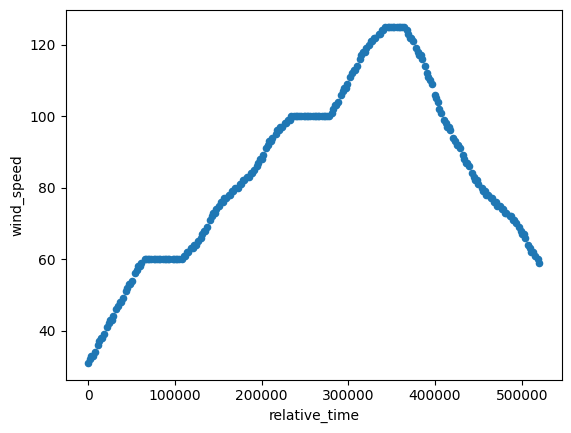

In [21]:
tst_storm.plot(x='relative_time', y='wind_speed', kind='scatter')

---
## ML Model no image as input --> RandomForest attempt just to see

In [22]:
tst_storm_to_predict = tst_storm[tst_storm['wind_speed'].isna()]
tst_storm_to_predict

,storm_id,relative_time,ocean,wind_speed,image_file_name
242,tst,522000,1,NaN,tst_242.jpg
243,tst,523800,1,NaN,tst_243.jpg
244,tst,525601,1,NaN,tst_244.jpg
245,tst,529199,1,NaN,tst_245.jpg
246,tst,530999,1,NaN,tst_246.jpg
247,tst,532799,1,NaN,tst_247.jpg
248,tst,534599,1,NaN,tst_248.jpg
249,tst,536398,1,NaN,tst_249.jpg
250,tst,539999,1,NaN,tst_250.jpg
251,tst,541799,1,NaN,tst_251.jpg


In [23]:
dataset = tst_storm
dataset = dataset.drop(['image_file_name', 'storm_id'], axis=1)
dataset = dataset.dropna()
dataset.head()

,relative_time,ocean,wind_speed
0,0,1,31.0
1,1800,1,32.0
2,3601,1,33.0
3,5400,1,33.0
4,7200,1,34.0


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define features and target variable
X = dataset.drop(['wind_speed'], axis=1)
y = dataset['wind_speed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(n_estimators=500, random_state=0, n_jobs=-1)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

model.fit(X_train, y_train)

predictions = model.predict(X_test)

# errors
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error: {mae:.2f} knots')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f} knots')
print("Cross-Validation rmse:", -cv_scores.mean())

# predict the wind speed for the tst_storm_to_predict dataset
predictions = model.predict(tst_storm_to_predict.drop(['wind_speed', 'image_file_name','storm_id'], axis=1))
predictions


Mean Absolute Error: 0.48 knots
Mean Squared Error: 0.39
Root Mean Squared Error: 0.63 knots
Cross-Validation rmse: 0.6556286182523335


array([60.546, 60.546, 60.546, 60.546, 60.546, 60.546, 60.546, 60.546,
       60.546, 60.546, 60.546, 60.546, 60.546])

---
## DL with image 

- to do: Exclude bkh and train

In [11]:
storm = storm.append(tst_storm)
storm

,storm_id,relative_time,ocean,wind_speed,image_file_name
0,mtw,0,1,30.0,mtw_000.jpg
1,mtw,1800,1,30.0,mtw_001.jpg
2,mtw,3600,1,30.0,mtw_002.jpg
3,mtw,5400,1,30.0,mtw_003.jpg
4,mtw,7200,1,30.0,mtw_004.jpg
...,...,...,...,...,...
250,tst,539999,1,NaN,tst_250.jpg
251,tst,541799,1,NaN,tst_251.jpg
252,tst,543599,1,NaN,tst_252.jpg
253,tst,545399,1,NaN,tst_253.jpg


In [13]:
dataset = storm
images_path = 'all_storm_image'
dataset = dataset.dropna()
dataset.head()

,storm_id,relative_time,ocean,wind_speed,image_file_name
0,mtw,0,1,30.0,mtw_000.jpg
1,mtw,1800,1,30.0,mtw_001.jpg
2,mtw,3600,1,30.0,mtw_002.jpg
3,mtw,5400,1,30.0,mtw_003.jpg
4,mtw,7200,1,30.0,mtw_004.jpg


In [14]:
# check size of tst in dataset 
tst = dataset[dataset['storm_id'] == 'tst']
tst

,storm_id,relative_time,ocean,wind_speed,image_file_name
0,tst,0,1,31.0,tst_000.jpg
1,tst,1800,1,32.0,tst_001.jpg
2,tst,3601,1,33.0,tst_002.jpg
3,tst,5400,1,33.0,tst_003.jpg
4,tst,7200,1,34.0,tst_004.jpg
...,...,...,...,...,...
237,tst,511201,1,62.0,tst_237.jpg
238,tst,513000,1,62.0,tst_238.jpg
239,tst,514800,1,61.0,tst_239.jpg
240,tst,518400,1,60.0,tst_240.jpg


0      all_storm_image/mtw_000.jpg
1      all_storm_image/mtw_001.jpg
2      all_storm_image/mtw_002.jpg
3      all_storm_image/mtw_003.jpg
4      all_storm_image/mtw_004.jpg
                  ...             
493    all_storm_image/ing_493.jpg
494    all_storm_image/ing_494.jpg
495    all_storm_image/ing_495.jpg
496    all_storm_image/ing_496.jpg
497    all_storm_image/ing_497.jpg
Name: image_file_name, Length: 9527, dtype: object


Epoch 1/6
239/239 [==============================] - 21s 82ms/step - loss: 3763.6138 - val_loss: 2004.6478
Epoch 2/6
239/239 [==============================] - 15s 62ms/step - loss: 2413.1619 - val_loss: 1780.0160
Epoch 3/6
239/239 [==============================] - 15s 63ms/step - loss: 958.0488 - val_loss: 550.7511
Epoch 4/6
239/239 [==============================] - 15s 63ms/step - loss: 354.6383 - val_loss: 253.1019
Epoch 5/6
239/239 [==============================] - 15s 64ms/step - loss: 256.9029 - val_loss: 403.4129
Epoch 6/6
298/298 [==============================] - 5s 15ms/step - loss: 531.4784
Mean Squared Error on Test Set: 531.48
Root Mean Squared Error on Test Set: 23.05


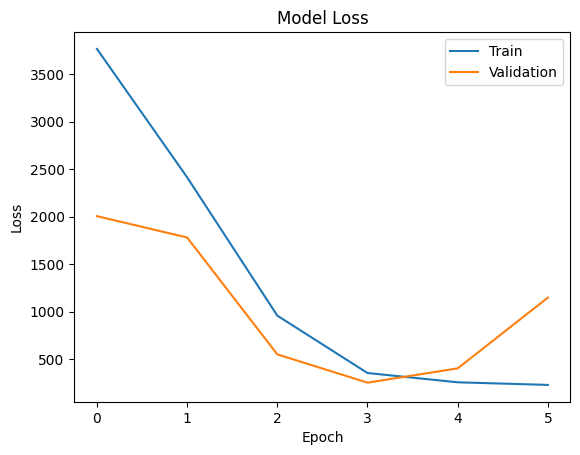

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

image_paths = dataset['image_file_name'].apply(lambda x: os.path.join(images_path, x))

print(image_paths)
image_data = np.array([img_preprocess_simple(path) for path in image_paths])
image_data = np.stack(image_data, axis=0) 

######### Network Architecture #########
image_input_layer = Input(shape=image_data.shape[1:], name='image_input')
image_flattened = Flatten()(image_input_layer)

image_branch = Dense(128, activation='relu')(image_flattened)
image_branch = BatchNormalization()(image_branch)  # Add batch normalization
image_branch = Dropout(0.15)(image_branch)
image_branch = Dense(64, activation='relu')(image_branch)
image_branch = BatchNormalization()(image_branch)  # Add batch normalization
image_branch = Dropout(0.3)(image_branch)

output_layer = Dense(1, name='output')(image_branch) 
#########################################

model = Model(inputs=[image_input_layer], outputs=output_layer) 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train for bkh images only and bkh wind_speed
history = model.fit({ 'image_input': image_data}, dataset['wind_speed'], epochs=6, batch_size=32, validation_split=0.2)

# Evaluate
mse = model.evaluate({ 'image_input': image_data}, dataset['wind_speed']) 
print(f'Mean Squared Error on Test Set: {mse:.2f}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on Test Set: {rmse:.2f}')

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# predict the wind speed for the tst_storm_to_predict dataset

mse :
- 900 with time
- 500 without time
- 430 without preprocessed and time
- 335 with lr = 0.001, 15 epochs
- 170 with 0.25 dropout everywhere 

rmse : 
- 17 with 0.35/0.3 dropout, lr = 0.001, everywhere 
- reverted resize from 260x260 to 366x366: 


16.9 with ocean data

16.43 without

without tabular branch (only image): 

242    all_storm_image/tst_242.jpg
243    all_storm_image/tst_243.jpg
244    all_storm_image/tst_244.jpg
245    all_storm_image/tst_245.jpg
246    all_storm_image/tst_246.jpg
247    all_storm_image/tst_247.jpg
248    all_storm_image/tst_248.jpg
249    all_storm_image/tst_249.jpg
250    all_storm_image/tst_250.jpg
251    all_storm_image/tst_251.jpg
252    all_storm_image/tst_252.jpg
253    all_storm_image/tst_253.jpg
254    all_storm_image/tst_254.jpg
Name: image_file_name, dtype: object
1/1 [==============================] - 0s 14ms/step


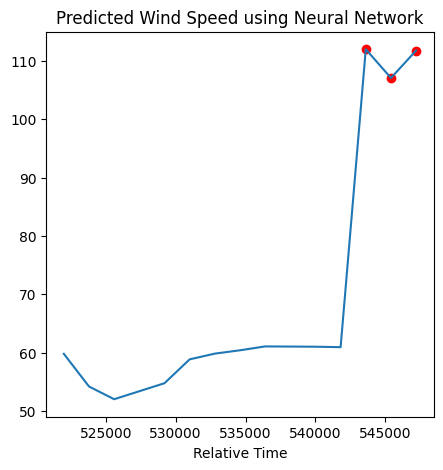

In [33]:
# predict the wind speed for the tst_storm_to_predict dataset associated image
images_for_prediction = tst_storm_to_predict['image_file_name'].apply(lambda x: os.path.join(images_path, x))
# print(images_for_prediction)
print(images_for_prediction)
image_data_for_prediction = np.array([img_preprocess_simple(path) for path in images_for_prediction])
image_data_for_prediction = np.stack(image_data_for_prediction, axis=0)
predictions = model.predict({ 'image_input': image_data_for_prediction})

plt.figure(figsize=(5, 5))
plt.plot(tst_storm_to_predict['relative_time'], predictions)
plt.scatter(tst_storm_to_predict['relative_time'].tail(3), predictions[-3:], color='red')
plt.xlabel('Relative Time')
plt.title('Predicted Wind Speed using Neural Network')
plt.show()


### Prediction on whole set

8/8 [==============================] - 0s 6ms/step


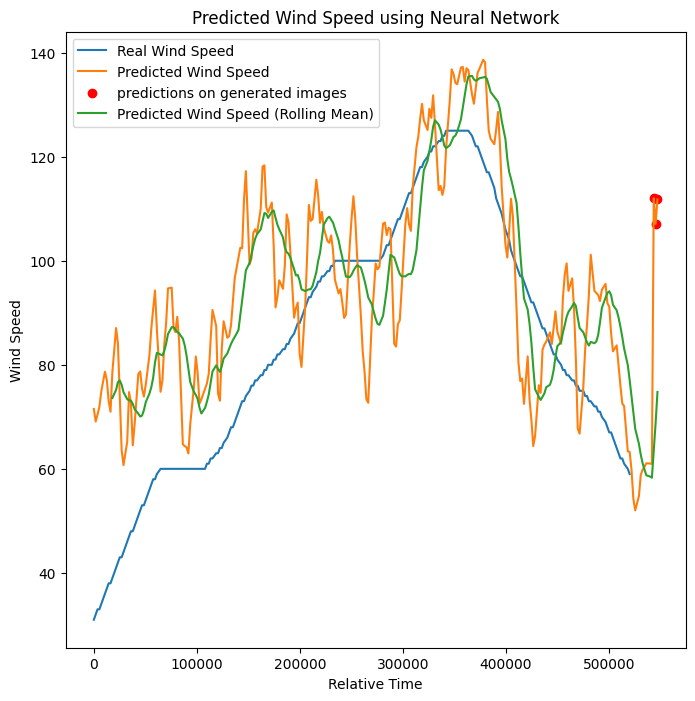

In [34]:
# tst predictions for all tst_storm not just tst_storm_to_predict

# recover dataset before the nan were dropped
dataset = storm

tst = dataset[dataset['storm_id'] == 'tst']
images_for_prediction = tst['image_file_name'].apply(lambda x: os.path.join(images_path, x))
image_data_for_prediction = np.array([img_preprocess_simple(path) for path in images_for_prediction])
image_data_for_prediction = np.stack(image_data_for_prediction, axis=0)
predictions = model.predict({ 'image_input': image_data_for_prediction})

# add predictions to tst dataframe
tst['predictions'] = predictions

# sort tst by relative_time
tst = tst.sort_values(by='relative_time')

# plot the predicted wind speed against the real wind speed for tst
plt.figure(figsize=(8, 8))
plt.plot(tst['relative_time'], tst['wind_speed'])
plt.plot(tst['relative_time'], predictions)
plt.scatter(tst['relative_time'].tail(3), predictions[-3:], color='red')

plt.plot(tst['relative_time'], tst['predictions'].rolling(window=10).mean())
plt.xlabel('Relative Time')
plt.ylabel('Wind Speed')
plt.title('Predicted Wind Speed using Neural Network')
plt.legend(['Real Wind Speed', 'Predicted Wind Speed','predictions on generated images', 'Predicted Wind Speed (Rolling Mean)'], loc='upper left')
plt.show()


In [32]:
tst

,storm_id,relative_time,ocean,wind_speed,image_file_name,storm_intensity,predictions
0,tst,0,1,31.0,tst_000.jpg,NaN,71.505997
1,tst,1800,1,32.0,tst_001.jpg,NaN,69.095444
2,tst,3601,1,33.0,tst_002.jpg,NaN,70.449203
3,tst,5400,1,33.0,tst_003.jpg,NaN,71.952988
4,tst,7200,1,34.0,tst_004.jpg,NaN,74.863327
...,...,...,...,...,...,...,...
250,tst,539999,1,NaN,tst_250.jpg,NaN,61.020718
251,tst,541799,1,NaN,tst_251.jpg,NaN,60.943096
252,tst,543599,1,NaN,tst_252.jpg,NaN,112.016609
253,tst,545399,1,NaN,tst_253.jpg,NaN,107.086525
